In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
RANDOM_SEED = random.randint(1, 1000)
RANDOM_SEED

816

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

In [4]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
ab = AdaBoostRegressor()
xgb = XGBRegressor()

mlp = MLPRegressor(hidden_layer_sizes = (30, 10, 5),
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=RANDOM_SEED)

In [5]:
param_grid = {
        'meta_regressor__n_estimators': [50, 100],
        # 'randomforestregressor__max_depth': [10, 15, 20, 25, 30, None],
        # 'xgbregressor__n_estimators': [50, 100]
        # 'meta_regressor__n_estimators': [100, 300, 400, 500, 600, 700, 800],
        # 'xgbregressor__max_depth': [ 5, 7, 9, None],
}

## Name a folder where all results will be stored for further inquiry

1. (gb, mlp, ab) (xgb)
2. (ab, xgb, gb) (mlp)
3. (xgb, gb, mlp) (ab)
4. (xgb, ab, mlp) (gb)

In [6]:
folder_name = 'xgb_gb_mlp-ab-' + str(RANDOM_SEED) # 3

In [7]:
level_1_regressor = (xgb, gb, mlp)
meta_regressor = ab 

In [8]:
import os

output_dir = "./output/" + folder_name + '/'
os.makedirs(output_dir, exist_ok=True)

#### Setting

In [9]:
grid_search_performance_score = 'grid_search_stacking_performance_score'
grid_search_train_test_data = 'grid_search_stacking_train_test_data'
grid_search_trained_model = 'grid_search_trained_stacking_model'

In [10]:
df = pd.read_csv('../data/processed_l55_cubic.csv')
df.head()

,depth,porosity,gr_density,w_saturation,o_saturation,k
0,2344.0,0.194,2680,0.398667,0.209000,132.00
1,2344.3,0.161,2710,0.537333,0.208182,4.48
2,2344.5,0.105,2710,0.676000,0.207364,0.06
3,2344.8,0.214,2670,0.284000,0.206545,63.40
4,2345.1,0.105,2710,0.676000,0.205727,0.06


In [11]:
# selecting features and label
X = df.iloc[:, :-1]  # features
y = df.iloc[:,-1]  # label
X.shape, y.shape

((197, 5), (197,))

#### Spliting into training and testing set for both X and y

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=RANDOM_SEED)

In [13]:
# function to convert seconds to into hours, minutes and seconds
# this function is used to measure the time taking by the models
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [14]:
# Define a range of hidden layer sizes to search over
# param_grid = {
#     'hidden_layer_sizes': [(10,), (50,), (100,), (50, 30), (50, 50), (30, 20), (100, 50, 25)]
# }

In [15]:
stack = StackingCVRegressor(regressors= level_1_regressor,
                            meta_regressor = meta_regressor, 
                            random_state=RANDOM_SEED,
                            use_features_in_secondary=True)

## Grid Search

In [16]:
grid_search = GridSearchCV(
    estimator=stack,
    param_grid=param_grid,
    cv=5,
    scoring=['neg_mean_squared_error', 'r2'], 
    refit='r2'
)

In [17]:
# grid_search.get_params()

In [18]:
import time
start = time.time() # starting of the time
grid_search.fit(X_train, y_train)
end = time.time() # ending of the time

print('run_time:', convert(end - start), 'h:m:s')

run_time: 0:00:06 h:m:s


In [19]:
# Save training time to a text file
with open(output_dir + 'grid_search_stacking_training_time.txt', 'w') as file:
    file.write(f"grid search stacking training time: {convert(end-start)} h:m:s\n")

In [20]:
pred_1 = grid_search.predict(X_train) # prediction for training set
pred_2 = grid_search.predict(X_test) # prediction for testing set

In [21]:
# saving training, testing and y data with their predicted data in a excel file with different sheets
a = np.stack([y_train, pred_1], axis=1) # training
a = pd.DataFrame(a, columns=['y_train', 'y_train_pred'])

b = np.stack([y_test, pred_2], axis=1) # testing 
b = pd.DataFrame(b, columns=['y_test', 'y_test_pred'])

with pd.ExcelWriter(output_dir + grid_search_train_test_data + '.xlsx') as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    a.to_excel(writer, sheet_name="training", index=True)
    b.to_excel(writer, sheet_name="testing", index=True)

In [22]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_percentage_error

train_r2 = r2_score(y_train,pred_1) # r2_score for training set
train_mae = mean_absolute_error(y_train, pred_1) # mean absolute error for training set
train_mse = mean_squared_error(y_train, pred_1) # mean squared error for training set
train_rmse = np.sqrt(mean_squared_error(y_train, pred_1)) # mean squared error for training set
train_mape = mean_absolute_percentage_error(y_train, pred_1)
train_maxE = max_error(y_train, pred_1)
train_minE = np.min(abs(y_train - pred_1))

test_r2 = r2_score(y_test, pred_2) # r2_score for testing set
test_mae = mean_absolute_error(y_test, pred_2) # mean absolute error for testing set
train_mse = mean_squared_error(y_train, pred_1) # mean squared error for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, pred_2)) # mean squared error for testing set
test_mape = mean_absolute_percentage_error(y_test, pred_2)
test_maxE = max_error(y_test, pred_2)
test_minE = np.min(abs(y_test - pred_2))

metrics = {
'performance_metrics': ['R2', 'MAE', 'RMSE', 'MAPE', 'maxE', 'minE'],
'training': [train_r2, train_mae, train_rmse, train_mape, train_maxE, train_minE],
'testing': [test_r2, test_mae, test_rmse, test_mape, test_maxE, test_minE],
}

performance_metrics = pd.DataFrame(metrics)
performance = performance_metrics.transpose()
performance.to_csv(output_dir + grid_search_performance_score + '.csv')
performance

,0,1,2,3,4,5
performance_metrics,R2,MAE,RMSE,MAPE,maxE,minE
training,0.937249,24.724562,30.435097,78.483368,72.882466,0.0
testing,0.925716,28.310103,41.513548,108.98859,160.0,0.515873


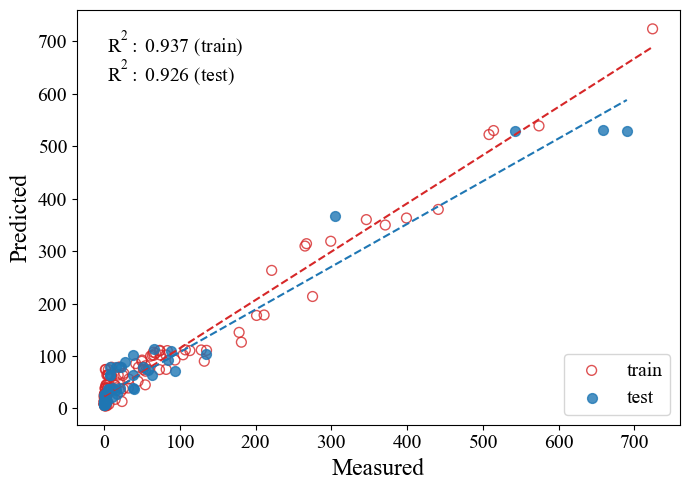

In [23]:
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['mathtext.bf'] = 'Times New Roman'
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=(7, 5))

sns.regplot(x=y_train, y=pred_1, scatter_kws={"color": "C3", "s": 50, "facecolors": "none"}, 
            line_kws={"color": "C3", "linestyle": "--", "linewidth": 1.5},
            label= 'train', ci=None, fit_reg=True)
sns.regplot(x=y_test, y=pred_2, scatter_kws={"color": "C0", "s": 50}, 
            line_kws={"color": "C0", "linestyle": "--", "linewidth": 1.5}, 
            label = 'test', ci=None, fit_reg=True)
plt.text(.05, .9, "$R^2:$ {:.3f} (train)".format(train_r2), fontsize=14, transform=plt.gca().transAxes)
plt.text(.05, .83, "$R^2:$ {:.3f} (test)".format(test_r2), fontsize=14, transform=plt.gca().transAxes)
plt.xlabel("Measured", fontsize=17)
plt.ylabel("Predicted", fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="lower right")

plt.tight_layout()
plt.savefig(output_dir + 'regression_plot.png', dpi=300)
plt.show()

In [24]:
# Saving the trained model
from joblib import dump, load
dump(grid_search, output_dir + grid_search_trained_model + '.joblib')

#clf = load(output_dir + grid_search_trained_model + '.joblib')

['./output/xgb_gb_mlp-ab-816/grid_search_trained_stacking_model.joblib']